# Portfolio Optimization Methods
* Monte Carlo, “brute force” style optimisation
* Scipy’s “optimize” function for “minimizing (or maximizing) objective functions, possibly subject to constraints”

# Import Required Modules

In [15]:
import pandas as pd
import numpy as np
from pandas_datareader import data, wb
import datetime
import scipy.optimize as sco
from scipy import stats

import matplotlib.pyplot as plt
%matplotlib inline

# Download price data for the stocks to include in our portfolio: Apple, Microsoft, Netflix, Amazon, Google

In [16]:
tickers = ['AAPL', 'MSFT', 'NFLX', 'AMZN', 'GOOG']
start = datetime.datetime(2010, 1, 1)
end = datetime.datetime(2018, 12, 31)

df = pd.DataFrame([data.DataReader(ticker, 'yahoo', start, end)['Adj Close'] for ticker in tickers]).T
df.columns = tickers

# Monte Carlo approach
#### With this approach we try to discover the optimal weights by simply creating a large number of random portfolios, all with varying combinations of constituent stock weightings, calculating and recording the Sharpe ratio of each of these randomly weighted portfolio and then finally extracting the details corresponding to the result with the highest value. The random weightings that we create will be bound by the constraint that they must be between zero and one for each of the individual stocks, and also that all the weights must sum to one to represent an investment of 100% of our theoretical capital. The more random portfolios that we create and calculate the Sharpe ratio for, theoretically the closer we get to the weightings of the “real” optimal portfolio. We will always experience some discrepancies however as we can never run enough simulated portfolios to replicate the exact weights we are searching for…we can get close, but never exact.

In [17]:
#Calculate the annualized return, annualized standard deviation and annualized Sharpe ratio of a portfolio.
#The arguments provided are, the weights of the portfolio constituents, the mean daily return of each of those constituents (as calculated over the historic data downloaded earlier), the co-variance matrix of the constituents and finally the risk free interest rate.
#The risk free rate is required for the calculation of the Sharpe ratio and should be provided as an annualized rate.
def calc_portfolio_perf(weights, mean_returns, cov, rf):
    portfolio_return = np.sum(mean_returns * weights) * 252
    portfolio_std = np.sqrt(np.dot(weights.T, np.dot(cov, weights))) * np.sqrt(252)
    sharpe_ratio = (portfolio_return - rf) / portfolio_std
    return portfolio_return, portfolio_std, sharpe_ratio

#Overall creation of multiple randomly weighted portfolios
#Randomly weighted portfolios are passed to the function above to calculate the required values to record
#The values are then recorded and once all portfolios have been simulated, the results are stored in and returned as a Pandas DataFrame.
def simulate_random_portfolios(num_portfolios, mean_returns, cov, rf):
    results_matrix = np.zeros((len(mean_returns) + 3, num_portfolios))
    for i in range(num_portfolios):
        weights = np.random.random(len(mean_returns))
        weights /= np.sum(weights)
        portfolio_return, portfolio_std, sharpe_ratio = calc_portfolio_perf(weights, mean_returns, cov, rf)
        results_matrix[0, i] = portfolio_return
        results_matrix[1, i] = portfolio_std
        results_matrix[2, i] = sharpe_ratio
        #iterate through the weight vector and ad data to results array
        for j in range(len(weights)):
            results_matrix[j + 3, i] = weights[j]
    results_df = pd.DataFrame(results_matrix.T, columns = ['ret', 'stdev', 'sharpe'] + [ticker for ticker in tickers])
    return results_df

In [18]:
#Calculate the mean returns and co-variance matrix of our list of stocks
#Set the number of portfolios to simulate
#Set the desired value of the risk free rate
#Call the required function and store the results in a variable to extract and visualise them.
mean_returns = df.pct_change().mean()
cov = df.pct_change().cov()
num_portfolios = 100000
rf = 0.0

results_frame = simulate_random_portfolios(num_portfolios, mean_returns, cov, rf)

# Visualization
#### Below we visualise the results of all the simulated portfolios, plotting each portfolio by it’s corresponding values of annualized return (y-axis) and annualized volatility (x-axis), and also identify the 2 portfolios we are interested in. These are highlighted with a red star for the maximum Sharp ratio portfolio, and a green star for the minimum variance portfolio.

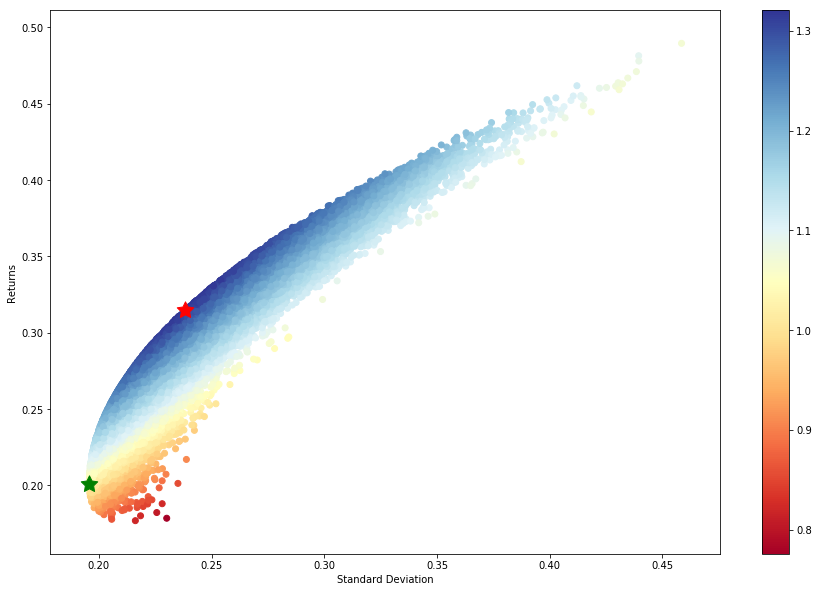

In [19]:
#locate position of portfolio with highest Sharpe Ratio
max_sharpe_portfolio = results_frame.iloc[results_frame['sharpe'].idxmax()]
#locate position of portfolio with minimum standard deviation
min_vol_portfolio = results_frame.iloc[results_frame['stdev'].idxmin()]
#create scatter plot colored by Sharpe Ratio
plt.subplots(figsize = (15,10))
plt.scatter(results_frame.stdev, results_frame.ret, c = results_frame.sharpe, cmap = 'RdYlBu')
plt.xlabel('Standard Deviation')
plt.ylabel('Returns')
plt.colorbar()
#plot red star to highlight position of portfolio with highest Sharpe Ratio
plt.scatter(max_sharpe_portfolio[1], max_sharpe_portfolio[0], marker = (5, 1, 0), color = 'r', s = 300)
#plot green star to highlight position of minimum variance portfolio
plt.scatter(min_vol_portfolio[1], min_vol_portfolio[0], marker = (5, 1, 0), color = 'g', s = 300)
plt.show()

#### Take a look at the stock weightings that made up those two portfolios, along with the annualized return, annualized standard deviation and annualized Sharpe ratio. These are shown below firstly for the maximum Sharpe portfolio, and then for the minimum variance portfolio.

In [20]:
max_sharpe_portfolio.to_frame().T

,ret,stdev,sharpe,AAPL,MSFT,NFLX,AMZN,GOOG
79584,0.314816,0.238366,1.320723,0.345335,0.174269,0.230302,0.246372,0.003722


In [21]:
min_vol_portfolio.to_frame().T

,ret,stdev,sharpe,AAPL,MSFT,NFLX,AMZN,GOOG
81563,0.200691,0.195649,1.025771,0.296933,0.408191,0.014431,0.024791,0.255653


# Scipy 'optimize' approach
#### The code is fairly brief but there are a couple of things worth mentioning. Firstly, Scipy offers a “minimize” function, but no “maximize” function. Saying as we wish to maximize the Sharpe ration, this may seem like a bit of a problem at first glance, but it is easily solved by realising that the maximization of the Sharpe ratio is analogous to the minimization of the negative Sharpe ratio – that is literally just the Sharpe ratio value with a minus sign stuck at the front.

#### So firstly we define a function (very similar to our earlier function) that calculates and returns the negative Sharpe ratio of a portfolio.

#### Then we define a variable I have labelled “constraints”. This can look somewhat strange at first if you haven’t used the Scipy “optimize” capabilities before.

#### Let me run through each entry and hopefully clarify them somewhat:

#### Firstly, as we will be using the ‘SLSQP’ method in our “minimize” function (which stands for Sequential Least Squares Programming), the constraints argument must be in the format of a list of dictionaries, containing the fields “type” and “fun”, with the optional fields “jac” and “args”. We only need the fields “type”, “fun” and “args” so lets run through them.

#### The “type” can be either “eq” or “ineq” referring to “equality” or “inequality” respectively. The “fun” refers to the function defining the constraint, in our case the constraint that the sum of the stock weights must be 1. The way this needs to be entered is sort of a bit “back to front”. The “eq” means we are looking for our function to equate to zero (this is what the equality is in reference to – equality to zero in effect). So the most simple way to achieve this is to create a lambda function that returns the sum of the portfolio weights, minus 1. The constraint that this needs to sum to zero (that the function needs to equate to zero) by definition means that the weights must sum to 1. It’s admittedly a bit strange looking for some people at first, but there you go…

#### The “bounds” just specify that each individual stock weight must be between 0 and 1, with the “args” being the arguments that we want to pass to the function we are trying to minimize (calc_neg_sharpe) – that is all the arguments EXCEPT the weights vector which of course is the variable we are changing to optimise the output.

In [22]:
def calc_neg_sharpe(weights, mean_returns, cov, rf):
    portfolio_return  = np.sum(mean_returns * weights) * 252
    portfolio_std = np.sqrt(np.dot(weights.T, np.dot(cov, weights))) * np.sqrt(252)
    sharpe_ratio = (portfolio_return - rf) / portfolio_std
    return -sharpe_ratio

constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})

def max_sharpe_ratio(mean_returns, cov, rf):
    num_assets = len(mean_returns)
    args = (mean_returns, cov, rf)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bound = (0.0, 1.0)
    bounds = tuple(bound for asset in range(num_assets))
    result = sco.minimize(calc_neg_sharpe, num_assets * [1./num_assets], args = args, method = 'SLSQP', bounds = bounds, constraints = constraints)
    return result

optimal_portfolio_sharpe = max_sharpe_ratio(mean_returns, cov, rf)

#### When we run the optimisation, we get the following results:

In [23]:
pd.DataFrame([round(x, 2) for x in optimal_portfolio_sharpe['x']], index = tickers).T

,AAPL,MSFT,NFLX,AMZN,GOOG
0,0.35,0.15,0.23,0.27,0.0


#### When we compare this output with that from our Monte Carlo approach we can see that they are similar, but of course as explained above they will not be identical. The weightings of each stock are not more than a couple of percent away between the two approaches.

#### We can then just use the same approach to identify the minimum variance portfolio. It’s almost the same code as above although this time we need to define a function to calculate and return the volatility of a portfolio, and use it as the function we wish the minimise (“calc_portfolio_std”). This time there is no need to negate the output of our function as it is already a minimization problem this time (as opposed to the Sharpe ratio when we wanted to find the maximum)

#### The constraints remain the same, so we just adapt the “max_sharpe_ratio” function above, rename it to “min_variance” and change the “args” variable to hold the correct arguments that we need to pass to our new “calc_portfolio_std” that we are minimising.

In [24]:
def calc_portfolio_std(weights, mean_returns, cov):
    portfolio_std = np.sqrt(np.dot(weights.T, np.dot(cov, weights))) * np.sqrt(252)
    return portfolio_std

def min_variance(mean_returns, cov):
    num_assets = len(mean_returns)
    args = (mean_returns, cov)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bound = (0.0, 1.0)
    bounds = tuple(bound for asset in range(num_assets))
    result = sco.minimize(calc_portfolio_std, num_assets * [1./num_assets,], args = args, method = 'SLSQP', bounds = bounds, constraints = constraints)
    return result

min_portfolio_variance = min_variance(mean_returns, cov)

#### When we run the optimisation, we get the following results:

In [25]:
pd.DataFrame([round(x, 2) for x in min_portfolio_variance['x']], index = tickers).T

,AAPL,MSFT,NFLX,AMZN,GOOG
0,0.28,0.4,0.02,0.02,0.27


#### Now let us move on to the problem of identifying the portfolio weights that minimise the Value at Risk (VaR).

#### The logic is very similar to that followed when dealing with the first Monte Carlo problem above. We start again by creating our two functions – but this time instead of one that returns portfolio return, volatility and Sharpe ratio, it returns the parametric portfolio VaR to a confidence level determined by the value of the “alpha” argument (confidence level will be 1 – alpha), and to a time scale determined by the “days” argument.

#### The method I have chosen to use for the VaR calculation is to scale the portfolio standard deviation by the square root of the “days” value, then subtract the scaled standard deviation, multiplied by the relevant “Z value” according to the chosen value of “alpha” from the portfolio daily mean returns which have been scaled linearly according to the “days” value. This final VaR value has then been converted to an absolute value, as VaR is more often than not reported as a positive value (it also allows us to run the required “minimization” function when it is cast as a positive value).

#### As a note, VaR is sometimes calculated in such a way that the mean returns of the portfolio are considered to be small enough that they can be entered into the equation with a zero value – this tends to make more sense when we are looking at VaR over short time periods like a daily or a weekly VaR figure, however when we start to look at annualized VaR figures it begins to make more sense to incorporate a “non-zero” return element.

#### Finally, the above approach where returns are entered as zero (effectively removing them from the calculation) is sometimes favoured as it is a more “pessimistic” view of a portfolio’s VaR and when dealing with the quantification of risk, or in fact any “downside” forecast, it is wise to err on the side of caution and make decisions based on a worst case scenario. The cost of being wrong due to underestimating VaR and that due to overestimating VaR is almost never symmetric – there is almost always a higher cost to an underestimation.

#### The second function is pretty much analogous to the one used for the Sharpe optimization with some slight changes to variable names, parameters and arguments passed of course.

In [26]:
def calc_portfolio_perf_VaR(weights, mean_returns, cov, alpha, days):
    portfolio_return = np.sum(weights * mean_returns) * days
    portfolio_std = np.sqrt(np.dot(weights.T, np.dot(cov, weights))) * np.sqrt(days)
    portfolio_var = abs(portfolio_return - (portfolio_std * stats.norm.ppf(1 - alpha)))
    return portfolio_return, portfolio_std, portfolio_var

def simulate_random_portfolios_VaR(num_portfolios, mean_returns, cov, alpha, days):
    results_matrix = np.zeros((len(mean_returns) + 3, num_portfolios))
    for i in range(num_portfolios):
        weights = np.random.random(len(mean_returns))
        weights /= np.sum(weights)
        portfolio_return, portfolio_std, portfolio_VaR = calc_portfolio_perf_VaR(weights, mean_returns, cov, alpha, days)
        results_matrix[0, i] = portfolio_return
        results_matrix[1, i] = portfolio_std
        results_matrix[2, i] = portfolio_VaR
        #iterate through the weight vector and add data to results array
        for j in range(len(weights)):
            results_matrix[j + 3, i] = weights[j]
    
    results_df = pd.DataFrame(results_matrix.T, columns=['ret', 'stdev', 'VaR'] + [ticker for ticker in tickers])
    return results_df

#### Similar variables are defined as before this time with the addition of “days” and “alpha”. The “days” variable determines the time frame over which the VaR figure is calculated/scaled and the “alpha” variable is the significance level used for the calculation (with confidence level being (1 – significance level) as mentioned just above).

#### I have chosen 252 days (to represent a year’s worth of trading days) and an alpha of 0.05, corresponding to a 95% confidence level. So that is to say we will be calculating the one-year 95% VaR, and attempting to minimise that value.

#### Now let’s run the simulation function and plot the results again.

In [27]:
mean_returns = df.pct_change().mean()
cov = df.pct_change().cov()
num_portfolios = 100000
rf = 0.0
days = 252
alpha = 0.05

results_frame = simulate_random_portfolios_VaR(num_portfolios, mean_returns, cov, alpha, days)

#### This time we plot the results of each portfolio with annualized return remaining on the y-axis but the x-axis this time representing the portfolio VaR (rather than standard deviation). The plot colors the data points according to the value of VaR for that portfolio.

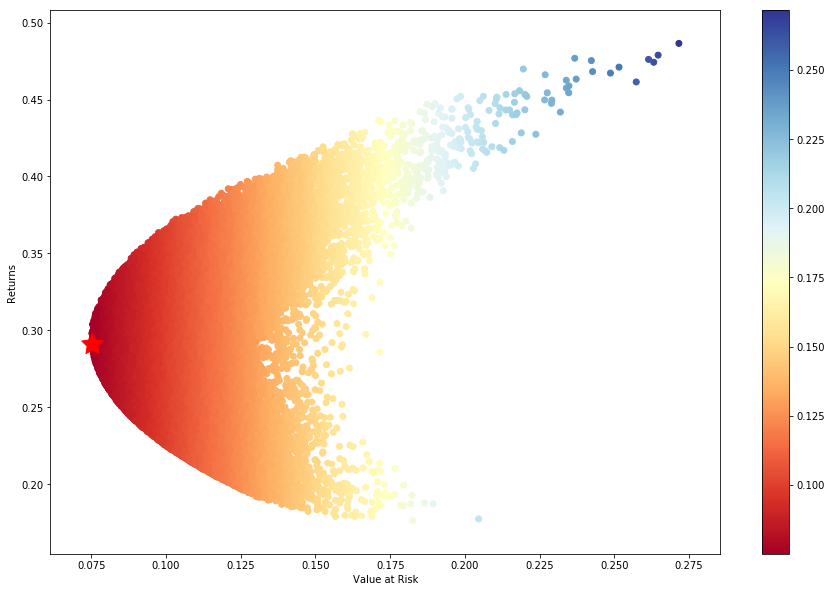

In [28]:
#locate position of portfolio with minimum VaR
min_VaR_portfolio = results_frame.iloc[results_frame['VaR'].idxmin()]
#create scatter plot colored by VaR
plt.subplots(figsize = (15, 10))
plt.scatter(results_frame.VaR, results_frame.ret, c = results_frame.VaR, cmap = 'RdYlBu')
plt.xlabel('Value at Risk')
plt.ylabel('Returns')
plt.colorbar()

#plot red star to highlight position of minimum VaR portfolio
plt.scatter(min_VaR_portfolio[2], min_VaR_portfolio[0], marker = (5, 1, 0), color = 'r', s = 500)
plt.show()

#### The weights of the resulting minimum VaR portfolio are as shown below.

In [29]:
min_VaR_portfolio.to_frame().T

,ret,stdev,VaR,AAPL,MSFT,NFLX,AMZN,GOOG
83092,0.290937,0.222554,0.075132,0.345856,0.264185,0.177067,0.209497,0.003395


#### What happens if we plot the location of the minimum VaR portfolio on a chart with the y-axis as return and the x-axis as standard deviation as before? The data points are still colored according to their corresponding VaR value. Let’s take a look.

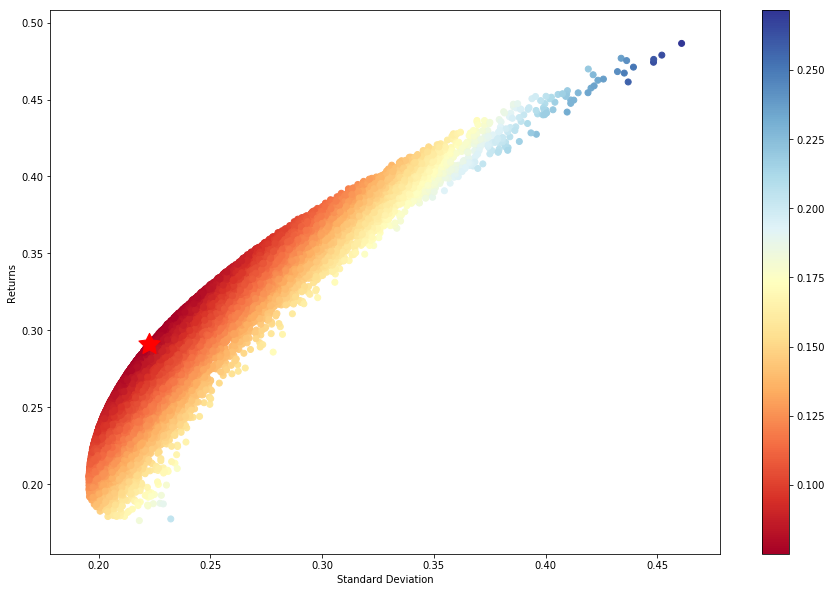

In [30]:
#locate position of portfolio with minimum VaR
min_VaR_portfolio = results_frame.iloc[results_frame['VaR'].idxmin()]
#create scatter plot colored by VaR
plt.subplots(figsize = (15, 10))
plt.scatter(results_frame.stdev, results_frame.ret, c = results_frame.VaR, cmap = 'RdYlBu')
plt.xlabel('Standard Deviation')
plt.ylabel('Returns')
plt.colorbar()

#plot red star to highlight position of minimum VaR portfolio
plt.scatter(min_VaR_portfolio[1], min_VaR_portfolio[0], marker = (5, 1, 0), color = 'r', s = 500)
plt.show()

#### Now you might notice at this point that the results of the minimum VaR portfolio simulations look pretty similar to those of the maximum Sharpe ratio portfolio but that is to be expected considering the calculation method chosen for VaR.

#### VaR Calculation:<br />rp - (z * qp)<br />rp = portfolio return, z = critical t, qp = portfolio std

#### Sharpe Ration Calculation:<br />(rp - rf) / qp<br />rp = portfolio return, qp = portfolio std, rf = risk free rate

#### From this we can see that VaR falls when portfolio returns increase and vice versa, whereas the Sharpe ratio increases as portfolio returns increase – so what minimizes VaR in terms of returns actually maximises the Sharpe ratio.

#### Similarly, an increase in portfolio standard deviation increases VaR but decreases the Sharpe ratio – so what maximizes VaR in terms of portfolio standard deviation actually minimizes the Sharpe ratio.

#### Seeing as we are looking for the minimum VaR and the maximum Sharpe, it makes sense that they will be be achieved with “similar” portfolios.

#### Now we move onto the second approach to identify the minimum VaR portfolio. The code is rather similar to the optimization code used to calculate the maximum Sharpe and minimum variance portfolios, with some minor tweaking.

#### We need a new function that calculates and returns just the VaR of a portfolio, which is defined first. Nothing changes here from our original function that calculated VaR, only that we return a single VaR value rather than the three original values (that previously included portfolio return and standard deviation).

#### The “min_VaR” function acts much as the “max_sharpe_ratio” and “min_variance” functions did, just with some tweaks to alter the arguments as needed. The constraints are the same, as are the bounds etc.

In [31]:
constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})

def calc_portfolio_VaR(weights, mean_returns, cov, alpha, days):
    portfolio_return = np.sum(mean_returns * weights) * days
    portfolio_std = np.sqrt(np.dot(weights.T, np.dot(cov, weights))) * np.sqrt(days)
    portfolio_var = abs(portfolio_return - (portfolio_std * stats.norm.ppf(1 - alpha)))
    return portfolio_var

def min_VaR(mean_returns, cov, alpha, days):
    num_assets = len(mean_returns)
    args = (mean_returns, cov, alpha, days)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bound = (0.0, 1.0)
    bounds = tuple(bound for asset in range(num_assets))
    result = sco.minimize(calc_portfolio_VaR, num_assets * [1./num_assets,], args = args, method = 'SLSQP', bounds = bounds, constraints = constraints)
    return result

min_portfolio_VaR = min_VaR(mean_returns, cov, alpha, days)

#### When we run the optimisation, we get the following results:

In [32]:
pd.DataFrame([round(x, 2) for x in min_portfolio_VaR['x']], index = tickers).T

,AAPL,MSFT,NFLX,AMZN,GOOG
0,0.35,0.24,0.18,0.23,0.0


#### Once again we see the results are very close to those we were presented with when using the Monte Carlo approach, with the weights being within a couple of percent of each other.